In [148]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as torch_d

In [149]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [150]:
class Receiver(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, M)

    def forward(self, y):
        y = self.lin1(y)
        return y

class Receiver2(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, 128)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(128, 128)
        self.act2 = nn.ReLU()
        self.lin3 = nn.Linear(128, M)

    def forward(self, y):
        y = self.act1(self.lin1(y))
        y = self.act2(self.lin2(y))
        return self.lin3(y)


class Encoder2(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, 128)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(128, M)

    def forward(self, y):
        y = self.act1(self.lin1(y))
        return self.lin2(y)

class Encoder(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, M, bias=False)
        nn.init.constant_(self.lin1.weight, 1 / M)

    def forward(self, y):
        return self.lin1(y)

class Mapper(nn.Module):
    def __init__(self, M):
        super().__init__()
        alphabet = np.arange(-(M-1),M,2)
        self.lin1 = nn.Linear(M, 1)
        self.lin1.weight = nn.Parameter(torch.Tensor([[i for i in alphabet]])) # set weigths equal to alphabet

    def forward(self, y):
        y = self.lin1(y)
        return y

class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.input = input
        return nn.functional.one_hot(torch.argmax(input, dim=-1), 8).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

In [151]:
def gradient_correction_factor(app, idx, prob, M):
    (nn,M)= app.shape
    cf  = torch.zeros(M)
    for j in range(M):
        tmp = app[:, j]
        cf[j] = torch.sum(torch.log(tmp[idx==j])) / (nn*prob[j]) # tmp[idx==j] selects the ll of those xy pairs which belong to the current symbol j
    return cf

In [152]:
def AWGN_channel(x, sigma2):
    noise_t = np.sqrt(sigma2)*torch.randn(x.shape)
    return x + noise_t

In [153]:
M = 8
n = 10_000
SNR_dB = 5
SNR = 10**(SNR_dB/10)
sigma2 = 1/SNR
nepochs = 4000

mapper = Mapper(M)
dec = Receiver2(M)
enc = Encoder2(M)
loss_fn = nn.CrossEntropyLoss()

In [154]:
for i in range(0, M):
    i_onehot = nn.functional.one_hot(torch.tensor(i), 8).float()
    print(mapper(i_onehot))

tensor([-6.8976], grad_fn=<AddBackward0>)
tensor([-4.8976], grad_fn=<AddBackward0>)
tensor([-2.8976], grad_fn=<AddBackward0>)
tensor([-0.8976], grad_fn=<AddBackward0>)
tensor([1.1024], grad_fn=<AddBackward0>)
tensor([3.1024], grad_fn=<AddBackward0>)
tensor([5.1024], grad_fn=<AddBackward0>)
tensor([7.1024], grad_fn=<AddBackward0>)


In [155]:
lr = 0.001
opt = optim.Adam( list(enc.parameters()) + list(dec.parameters()) + list(mapper.parameters()), lr=lr)

In [156]:
def sampler(logits, n, M):
    temperature = 10
    estimator = STEFunction.apply
    g_dist = torch_d.Gumbel(loc=torch.tensor([0.]), scale=torch.tensor([1.])) # create Gumbel dist
    g = g_dist.sample(sample_shape=[n, M]).squeeze()
    s_bar = nn.functional.softmax(input=((g + logits) / temperature), dim=1)
    s = estimator(s_bar) # straight through estimator
    return s

for j in range(nepochs):
    logits = enc(torch.tensor([1], dtype=torch.float))

    # Sample indexes
    # onehot = sampler(probs, n, M)
    onehot = nn.functional.gumbel_softmax(logits.expand(n, -1), tau=10, hard=True)
    indices = torch.argmax(onehot, dim=1)

    # Modulation
    alphabet_t = mapper(nn.functional.one_hot(torch.arange(M),M).float()).squeeze()
    probs =  nn.functional.softmax(logits, -1)
    norm_factor = torch.rsqrt(torch.sum(torch.pow(torch.abs(alphabet_t), 2) * probs))
    alphabet_norm =  alphabet_t * norm_factor
    symbols = torch.matmul(onehot, torch.transpose(input=alphabet_norm.reshape(1,-1), dim0=0, dim1=1))

    # Channel
    y = AWGN_channel(symbols, sigma2)

    # Demodulator
    ll = dec(y.reshape(-1,1))
    # app = nn.functional.softmax(ll, 1) #Q(X|Y)

    # Loss
    loss = -(torch.sum(-probs*torch.log(probs)) - loss_fn(ll, indices.detach()))# -(H(X) - CE(P,Q)), the gradient descent minimizes, therefore we minimize the opposite to maximize the MI in the end.
    opt.zero_grad()
    loss.backward()

    opt.step()

    # Printout and visualization
    if j % 500 == 0:
        print(f'epoch {j}: Loss = {loss.detach().numpy() / np.log(2) :.4f}')

epoch 0: Loss = 0.1414
epoch 500: Loss = -1.0213
epoch 1000: Loss = -1.0248
epoch 1500: Loss = -1.0120
epoch 2000: Loss = -1.0289
epoch 2500: Loss = -1.0428
epoch 3000: Loss = -1.0203
epoch 3500: Loss = -1.0183


In [157]:
probs

tensor([0.0200, 0.0896, 0.1686, 0.2215, 0.2218, 0.1676, 0.0905, 0.0203],
       grad_fn=<SoftmaxBackward0>)

In [158]:
symbols

tensor([[ 0.2734],
        [ 0.2734],
        [-0.2768],
        ...,
        [ 0.8955],
        [-0.2768],
        [ 0.2734]], grad_fn=<MmBackward0>)

In [159]:
torch.sum(probs)

tensor(1.0000, grad_fn=<SumBackward0>)

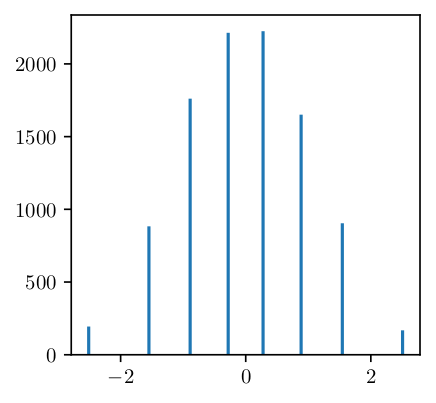

In [160]:
plt.rcParams['figure.figsize'] = [3, 3]
plt.hist(symbols.detach().numpy(), bins=100)
plt.savefig('/home/ddeandres/Projects/internship_pcs/documentation/figs/stark_gcs_{}dB.pgf'.format(SNR_dB))

/tmp/ipykernel_1850426/2165226770.py:10: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


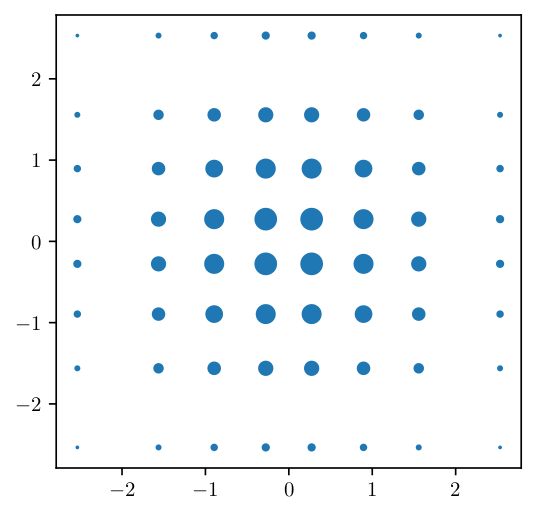

In [161]:
# Scatterplot
plt.rcParams['figure.figsize'] = [4, 4]
pp = (probs.reshape(-1,1)*probs.reshape(1,-1)).reshape(-1,1).detach().numpy()
alph = alphabet_norm.detach().numpy()
a = []
for c in np.flip(alph):
    for d in alph:
        a.append(d+1j*c)
plt.scatter(np.real(a), np.imag(a), pp*2000)   
plt.show()

### Compare Results

In [162]:
def AWGN_channel_np(x, sigma2):
    noise = np.sqrt(sigma2) * np.random.randn(x.size)
    return x + noise

In [163]:
def AWGNdemapper(y, const, varN):
    apps = np.exp(-np.abs(np.transpose([y])-const)**2/(2*varN))
    return apps / np.transpose([np.sum(apps, 1)])

In [164]:
def xesmd(apps, idx):
    """
    Estimates symbolwise equivocation from reference symbols indices and a posteriori probabilities.
    """
    eq = -np.log(np.take_along_axis(apps, idx[:, None], axis=1) / np.transpose([np.sum(apps, 1)]))
    eq[eq==np.inf] = 1000
    return np.mean(eq)

In [165]:
n = 10_000
SNR_dBs = np.arange(5,22)
M = 8
alphabet = np.arange(-7,8,2)
alphabet = alphabet / np.sqrt(np.mean(alphabet**2))
indices = np.random.choice(np.arange(M), n)
symbols_64 = alphabet[indices]

mi_64 = []
for snrdB in SNR_dBs:
    sigma2 = 1/(10**(snrdB/10))
    sigma2 = sigma2 
    y = AWGN_channel_np(symbols_64, sigma2)
    apps = AWGNdemapper(y, alphabet, sigma2)
    xe = xesmd(apps, indices)
    mi_64.append(2*(3 - (xe) / np.log(2)))

In [166]:
print((-2*loss.detach()/np.log(2)).detach().numpy())

2.0395608


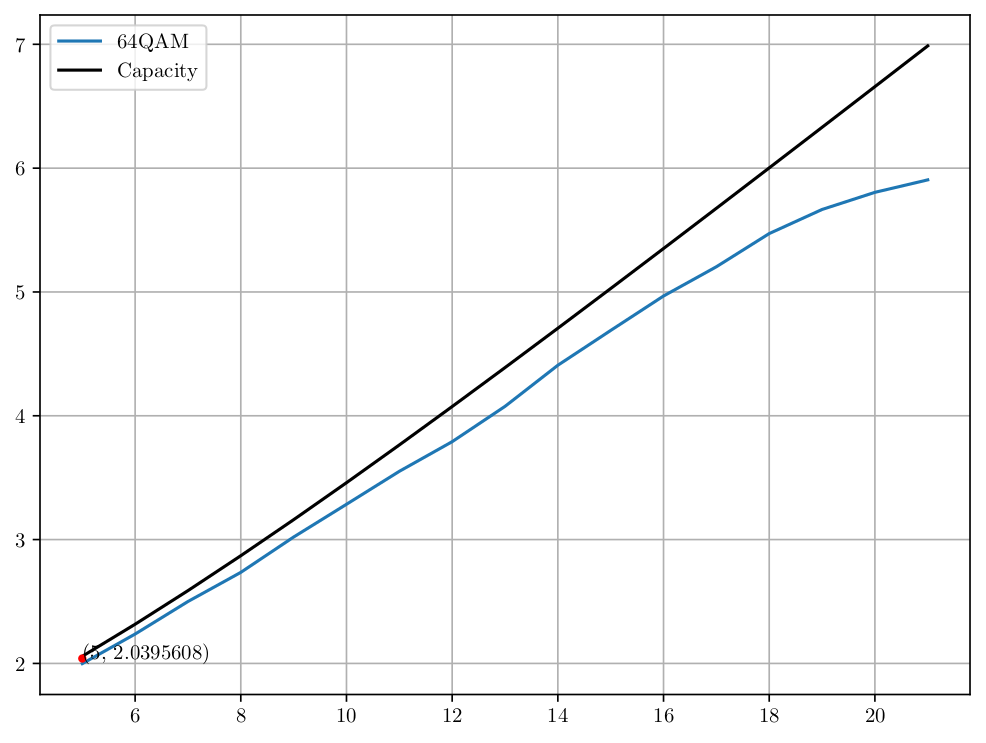

In [167]:
# Plot
plt.rcParams['figure.figsize'] = [8, 6]
plt.plot(SNR_dBs, mi_64, label = '64QAM')
plt.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)), color='black', label='Capacity')

plt.plot(SNR_dB, -2*loss.detach()/np.log(2), color='red', marker='o', markersize=3)
xy = (SNR_dB, (-2*loss.detach()/np.log(2)).detach().numpy())
plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.legend()
plt.grid()